# SpotFake: Twitter Fake News Detection with ResNet50 + BERT

This notebook provides a clean implementation for:
1. Loading and preprocessing data (text + images)
2. Building the multimodal model (BERT + ResNet50)
3. Loading pre-trained weights
4. Making predictions on new inputs (text + image)

In [1]:
# !python -m venv .venv
# !.venv\Scripts\Activate.ps1
# !pip install -r requirements.txt

## 1. Imports and Setup

In [2]:
import os
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm
tqdm.pandas()
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
from os import listdir
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

import tensorflow as tf
import tensorflow_hub as hub
from transformers import BertTokenizer
from tensorflow.keras import backend as K

import gc

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Suppress TF warnings
tf.get_logger().setLevel('ERROR')

print("TensorFlow version:", tf.__version__)
print("✓ All imports successful!")

e:\RP\SpotFake02\venv\Lib\site-packages\tensorflow_hub\__init__.py:61: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import parse_version



TensorFlow version: 2.20.0
✓ All imports successful!


In [3]:
# Configuration
bert_path = "https://tfhub.dev/google/bert_uncased_L-12_H-768_A-12/1"
max_seq_length = 23
img_length = 224
img_width = 224
img_channels = 3

In [4]:
# Test BERT model loading
try:
    print("Testing BERT model download and loading...")
    test_bert = hub.KerasLayer(bert_path, trainable=False, signature="tokens", signature_outputs_as_dict=True)
    print("✓ BERT model loaded successfully!")
    del test_bert
except Exception as e:
    print(f"❌ Error loading BERT model: {e}")
    print("\nTrying to clear TensorFlow Hub cache...")
    import shutil
    cache_dir = os.path.join(os.environ.get('LOCALAPPDATA', ''), 'Temp', 'tfhub_modules')
    if os.path.exists(cache_dir):
        shutil.rmtree(cache_dir)
        print(f"✓ Cache cleared: {cache_dir}")
        print("Please re-run this cell to download BERT model again.")
    else:
        print(f"Cache directory not found: {cache_dir}")

Testing BERT model download and loading...
✓ BERT model loaded successfully!


## 2. Helper Functions

### Text Preprocessing Functions

In [5]:
class PaddingInputExample(object):
    """Fake example for padding."""

class InputExample(object):
    """A single training/test example for simple sequence classification."""
    def __init__(self, guid, text_a, text_b=None, label=None):
        self.guid = guid
        self.text_a = text_a
        self.text_b = text_b
        self.label = label

def create_tokenizer_from_hub_module():
    """Get the BERT tokenizer."""
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    return tokenizer

def convert_single_example(tokenizer, example, max_seq_length=256):
    """Converts a single InputExample into features."""
    if isinstance(example, PaddingInputExample):
        input_ids = [0] * max_seq_length
        input_mask = [0] * max_seq_length
        segment_ids = [0] * max_seq_length
        label = 0
        return input_ids, input_mask, segment_ids, label

    encoding = tokenizer(
        example.text_a,
        truncation=True,
        padding='max_length',
        max_length=max_seq_length,
        return_tensors='tf'
    )
    
    input_ids = encoding['input_ids'][0].numpy().tolist()
    input_mask = encoding['attention_mask'][0].numpy().tolist()
    segment_ids = [0] * max_seq_length
    
    return input_ids, input_mask, segment_ids, example.label

def convert_examples_to_features(tokenizer, examples, max_seq_length=256):
    """Convert a set of InputExamples to features."""
    input_ids, input_masks, segment_ids, labels = [], [], [], []
    for example in tqdm(examples, desc="Converting examples to features"):
        input_id, input_mask, segment_id, label = convert_single_example(
            tokenizer, example, max_seq_length
        )
        input_ids.append(input_id)
        input_masks.append(input_mask)
        segment_ids.append(segment_id)
        labels.append(label)
    return (
        np.array(input_ids),
        np.array(input_masks),
        np.array(segment_ids),
        np.array(labels).reshape(-1, 1),
    )

def convert_text_to_examples(texts, labels):
    """Create InputExamples from texts and labels."""
    InputExamples = []
    for text, label in zip(texts, labels):
        InputExamples.append(
            InputExample(guid=None, text_a=text if isinstance(text, str) else " ".join(text), text_b=None, label=label)
        )
    return InputExamples

def preprocess_text_input(text, tokenizer, max_seq_length=23):
    """Preprocess a single text input for prediction."""
    example = InputExample(guid=None, text_a=text, text_b=None, label=0)
    input_id, input_mask, segment_id, _ = convert_single_example(
        tokenizer, example, max_seq_length
    )
    return np.array([input_id]), np.array([input_mask]), np.array([segment_id])

print("✓ Text preprocessing functions defined")

✓ Text preprocessing functions defined


### Image Preprocessing Functions

In [6]:
def read_and_process_image(list_of_images, length=224, width=224):
    """Read and preprocess multiple images."""
    X = [] 
    for image in tqdm(list_of_images, desc="Processing images"):
        img = cv2.imread(image, cv2.IMREAD_COLOR)
        img = cv2.resize(img, (length, width), interpolation=cv2.INTER_CUBIC)
        X.append(img)
    return np.array(X)

def preprocess_single_image(image_path, length=224, width=224):
    """Preprocess a single image for prediction."""
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        raise ValueError(f"Could not read image from {image_path}")
    img = cv2.resize(img, (length, width), interpolation=cv2.INTER_CUBIC)
    # Convert to (channels, height, width) format
    img = np.rollaxis(img, 2, 0)
    return np.expand_dims(img, axis=0)  # Add batch dimension

print("✓ Image preprocessing functions defined")

✓ Image preprocessing functions defined


## 3. Model Definition (BERT + ResNet50)

In [7]:
def get_news_model_resnet(params):
    """Build the multimodal fake news detection model using ResNet50."""
    tf.keras.backend.clear_session()
    
    # Load BERT layer once
    print("Loading BERT model from TensorFlow Hub...")
    bert_layer = hub.KerasLayer(
        bert_path,
        trainable=False,
        signature="tokens",
        signature_outputs_as_dict=True,
    )
    print("✓ BERT model loaded successfully")
    
    def bert_encode(input_ids, input_mask, segment_ids):
        bert_inputs = {
            "input_ids": input_ids, 
            "input_mask": input_mask, 
            "segment_ids": segment_ids
        }
        bert_outputs = bert_layer(bert_inputs)
        return bert_outputs["pooled_output"]

    # Text input branch
    in_id = tf.keras.layers.Input(shape=(max_seq_length,), name="input_ids", dtype=tf.int32)
    in_mask = tf.keras.layers.Input(shape=(max_seq_length,), name="input_masks", dtype=tf.int32)
    in_segment = tf.keras.layers.Input(shape=(max_seq_length,), name="segment_ids", dtype=tf.int32)
    
    bert_output = tf.keras.layers.Lambda(
        lambda inputs: bert_encode(inputs[0], inputs[1], inputs[2]),
        output_shape=(768,),
        name="bert_encoding"
    )([in_id, in_mask, in_segment])

    if params['text_no_hidden_layer'] > 0:
        for i in range(params['text_no_hidden_layer']):
            bert_output = tf.keras.layers.Dense(params['text_hidden_neurons'], activation='relu')(bert_output)
            bert_output = tf.keras.layers.Dropout(params['dropout'])(bert_output)

    text_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(bert_output)

    # Image input branch (ResNet50)
    conv_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    conv_base.trainable = False

    input_image = tf.keras.layers.Input(shape=(3, 224, 224))
    transposed_image = tf.keras.layers.Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(input_image)
    
    # ResNet50 has its own preprocessing function, but for consistency with the original
    # notebook and weights, we will just use the transposed image.
    # If training from scratch, it would be better to use:
    # preprocessed_image = tf.keras.applications.resnet50.preprocess_input(transposed_image)
    # base_output = conv_base(preprocessed_image)
    
    base_output = conv_base(transposed_image)
    flat = tf.keras.layers.Flatten()(base_output)

    if params['vis_no_hidden_layer'] > 0:
        for i in range(params['vis_no_hidden_layer']):
            flat = tf.keras.layers.Dense(params['vis_hidden_neurons'], activation='relu')(flat)
            flat = tf.keras.layers.Dropout(params['dropout'])(flat)

    visual_repr = tf.keras.layers.Dense(params['repr_size'], activation='relu')(flat)

    # Classifier (combine text + image)
    combine_repr = tf.keras.layers.concatenate([text_repr, visual_repr])
    com_drop = tf.keras.layers.Dropout(params['dropout'])(combine_repr)

    if params['final_no_hidden_layer'] > 0:
        for i in range(params['final_no_hidden_layer']):
            com_drop = tf.keras.layers.Dense(params['final_hidden_neurons'], activation='relu')(com_drop)
            com_drop = tf.keras.layers.Dropout(params['dropout'])(com_drop)

    prediction = tf.keras.layers.Dense(1, activation='sigmoid')(com_drop)

    model = tf.keras.models.Model(inputs=[in_id, in_mask, in_segment, input_image], outputs=prediction)
    model.compile(loss='binary_crossentropy', optimizer=params['optimizer'](), metrics=['accuracy'])
    
    return model

print("✓ ResNet50 Model definition ready")

✓ ResNet50 Model definition ready


## 4. Build Model and Load Weights

In [11]:
# Hyperparameters (these should match the ones used for training the ResNet50 model)
# The flattened output of ResNet50 is (7, 7, 2048) = 100352, which is different from VGG19.
# The 'vis_hidden_neurons' might need to be adjusted if you were training from scratch.
# For loading pre-trained weights, we use the original parameters.
params_final = {
    'text_no_hidden_layer': 1,
    'text_hidden_neurons': 768,
    'dropout': 0.4,
    'repr_size': 32,
    'vis_no_hidden_layer': 1,
    'vis_hidden_neurons': 2742, # This was for VGG19, but we keep it to match the saved model structure
    'final_no_hidden_layer': 1,
    'final_hidden_neurons': 35,
    'optimizer': tf.keras.optimizers.Adam
}

print("Model parameters:")
for k, v in params_final.items():
    print(f"  {k}: {v}")

# Build model
model = get_news_model_resnet(params_final)
model.summary()

Model parameters:
  text_no_hidden_layer: 1
  text_hidden_neurons: 768
  dropout: 0.4
  repr_size: 32
  vis_no_hidden_layer: 1
  vis_hidden_neurons: 2742
  final_no_hidden_layer: 1
  final_hidden_neurons: 35
  optimizer: <class 'keras.src.optimizers.adam.Adam'>
Loading BERT model from TensorFlow Hub...
✓ BERT model loaded successfully


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 3, 224,    │          0 │ -                 │
│ (InputLayer)        │ 224)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_ids           │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_masks         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ segment_ids         │ (None, 23)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resnet50            │ (None, 7, 7,      │ 23,587,712 │ lambda[0][0]      │
│ (Functional)        │ 2048)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bert_encoding       │ (None, 768)       │          0 │ input_ids[0][0],  │
│ (Lambda)            │                   │            │ input_masks[0][0… │
│                     │                   │            │ segment_ids[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 100352)    │          0 │ resnet50[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 768)       │    590,592 │ bert_encoding[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 2742)      │ 275,167,9… │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 768)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 2742)      │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │     24,608 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 32)        │     87,776 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 64)        │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 64)        │          0 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 35)        │      2,275 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 35)        │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │         36 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 299,460,925 (1.12 GB)

 Trainable params: 275,873,213 (1.03 GB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [12]:
# Load the pre-trained ResNet50 weights
# This file should correspond to the model trained with ResNet50
resnet_weights_file = 'spotfake_resnet50_multi_gpu_final.weights.h5'

if os.path.exists(resnet_weights_file):
    print(f"Loading weights from '{resnet_weights_file}'...")
    try:
        model.load_weights(resnet_weights_file)
        print("✓ Weights loaded successfully!")
    except Exception as e:
        print(f"❌ Error loading weights: {e}")
        print("Please ensure the model architecture matches the weights file.")
else:
    print(f"❌ Weights file not found: '{resnet_weights_file}'")
    print("Cannot proceed with inference. Please provide the correct weights file.")

Loading weights from 'spotfake_resnet50_multi_gpu_final.weights.h5'...


e:\RP\SpotFake02\venv\Lib\site-packages\keras\src\saving\saving_lib.py:797: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


❌ Error loading weights: A total of 1 objects could not be loaded. Example error message for object <Dense name=dense_2, built=True>:

Unable to allocate 21.4 MiB for an array with shape (2048, 2742) and data type float32

List of objects that could not be loaded:
[<Dense name=dense_2, built=True>]
Please ensure the model architecture matches the weights file.


## 5. Inference on New Input

Use this section to make predictions on new text + image pairs using the ResNet50-based model.

In [13]:
# Initialize tokenizer
tokenizer = create_tokenizer_from_hub_module()

def predict_fake_news(text, image_path, model, tokenizer, threshold=0.5):
    """
    Predict whether a news post (text + image) is fake or real.
    """
    # Preprocess text
    input_ids, input_masks, segment_ids = preprocess_text_input(
        text, tokenizer, max_seq_length=max_seq_length
    )
    
    # Preprocess image
    image_data = preprocess_single_image(image_path, length=img_length, width=img_width)
    
    # Make prediction
    prediction = model.predict(
        [input_ids, input_masks, segment_ids, image_data],
        verbose=0
    )[0][0]
    
    # Classify
    is_real = prediction >= threshold
    label = "REAL" if is_real else "FAKE"
    confidence = prediction if is_real else (1 - prediction)
    
    return {
        'label': label,
        'confidence': float(confidence),
        'raw_score': float(prediction),
        'text': text,
        'image_path': image_path
    }

print("✓ Inference function ready")

✓ Inference function ready


### Example: Make a Prediction

TensorFlow and JAX classes are deprecated and will be removed in Transformers v5. We recommend migrating to PyTorch classes or pinning your version of Transformers.



PREDICTION RESULT (ResNet50 + BERT)
Text: RT @welt: Yasmin Fahimi: #Pegida-Organisatoren sind geistige Brandstifter http://t.co/qD2mMrvxTS http://t.co/sMX6wxKKZL
Image: dataset/twitter/images_test/protest_5.jpg

Prediction: FAKE
Confidence: 92.76%
Raw Score: 0.0724


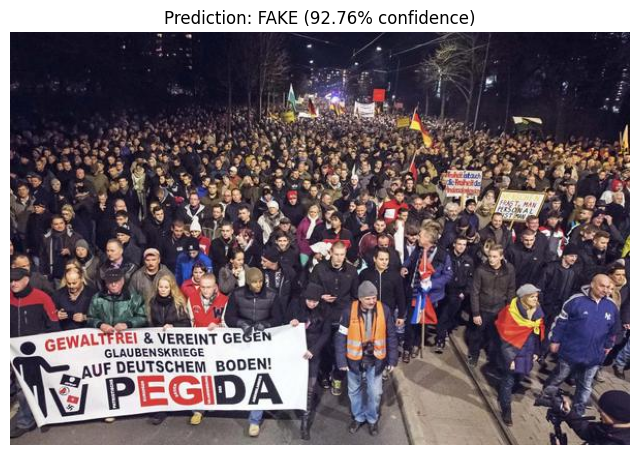

In [14]:
# Example usage
# Replace with your own text and image path

my_text = "RT @welt: Yasmin Fahimi: ""#Pegida-Organisatoren sind geistige Brandstifter"" http://t.co/qD2mMrvxTS http://t.co/sMX6wxKKZL"
my_image = "dataset/twitter/images_test/protest_5.jpg"

if os.path.exists(my_image):
    # Get prediction
    result = predict_fake_news(my_text, my_image, model, tokenizer)
    print("\n" + "="*50)
    print("PREDICTION RESULT (ResNet50 + BERT)")
    print("="*50)
    print(f"Text: {result['text']}")
    print(f"Image: {result['image_path']}")
    print(f"\nPrediction: {result['label']}")
    print(f"Confidence: {result['confidence']:.2%}")
    print(f"Raw Score: {result['raw_score']:.4f}")
    print("="*50)

    # Display the image
    img = cv2.imread(my_image)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(8, 6))
    plt.imshow(img_rgb)
    plt.title(f"Prediction: {result['label']} ({result['confidence']:.2%} confidence)")
    plt.axis('off')
    plt.show()
else:
    print(f"Image not found at: {my_image}")

## 6. Comprehensive Test Set Predictions

This section runs predictions on the entire test set from `test_posts.csv` and provides a detailed analysis of the model's performance.

In [ ]:
def predict_batch(texts, image_paths, model, tokenizer, threshold=0.5):
    """
    Make predictions on multiple text-image pairs.
    """
    results = []
    for text, img_path in tqdm(zip(texts, image_paths), total=len(texts), desc="Making predictions"):
        try:
            result = predict_fake_news(text, img_path, model, tokenizer, threshold)
            results.append(result)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            results.append({
                'label': 'ERROR',
                'confidence': 0.0,
                'raw_score': 0.0,
                'text': text,
                'image_path': img_path,
                'error': str(e)
            })
    return results

print("✓ Batch prediction function ready")

In [ ]:
# Extract and prepare data for prediction
def prepare_test_data_from_csv(csv_file, images_folder='dataset/twitter/images_test'):
    """
    Extract text and image paths from test CSV file.
    """
    df = pd.read_csv(csv_file)
    df['first_image_id'] = df['image_id'].apply(lambda x: x.split(',')[0].strip())
    
    # Get image extensions
    images = listdir(images_folder)
    ext_map = {}
    for img in images:
        if '.' in img and not img.startswith('.'):
            name, ext = os.path.splitext(img)
            ext_map[name] = ext
            
    def get_extension(file_name):
        return ext_map.get(file_name, '.jpg') # Default to .jpg if not found
    
    df['image_path'] = df['first_image_id'].apply(
        lambda x: f"{images_folder}/{x}{get_extension(x)}"
    )
    df['image_exists'] = df['image_path'].apply(os.path.exists)
    
    df_valid = df[df['image_exists']].copy()
    
    print(f"Total samples in CSV: {len(df)}")
    print(f"Valid samples with images: {len(df_valid)}")
    print(f"Missing images: {len(df) - len(df_valid)}\n")
    
    texts = df_valid['post_text'].tolist()
    image_paths = df_valid['image_path'].tolist()
    image_ids = df_valid['first_image_id'].tolist()
    labels = df_valid['label'].apply(lambda x: 1 if x == 'real' else 0).tolist()
    
    return texts, image_paths, labels, image_ids, df_valid

# Prepare test data
test_texts, test_imgs, test_labels, test_ids, test_df_valid = prepare_test_data_from_csv(
    'dataset/twitter/test_posts.csv'
)

print(f"Ready to predict on {len(test_texts)} samples")

In [ ]:
# Run predictions on all test samples
if 'model' in locals() and len(test_texts) > 0:
    print("Running predictions on all test samples with ResNet50 model...")
    print("This may take a few minutes...\n")

    all_predictions = predict_batch(test_texts, test_imgs, model, tokenizer)

    print(f"\n✓ Predictions completed for {len(all_predictions)} samples")
else:
    print("Skipping prediction, model not loaded or no test data found.")
    all_predictions = []

In [ ]:
# Create comprehensive results DataFrame
if all_predictions:
    results_df = pd.DataFrame({
        'image_id': test_ids,
        'text': test_texts,
        'image_path': test_imgs,
        'true_label': ['REAL' if l == 1 else 'FAKE' for l in test_labels],
        'predicted_label': [p['label'] for p in all_predictions],
        'confidence': [p['confidence'] for p in all_predictions],
        'raw_score': [p['raw_score'] for p in all_predictions],
    })
    results_df['correct'] = results_df['true_label'] == results_df['predicted_label']
    results_df['true_label_numeric'] = results_df['true_label'].apply(lambda x: 1 if x == 'REAL' else 0)
    results_df['predicted_label_numeric'] = results_df['predicted_label'].apply(lambda x: 1 if x == 'REAL' else 0)

    print("Results DataFrame created successfully!")
    print(f"Total predictions: {len(results_df)}")
    display(results_df.head(10))
else:
    print("No predictions were made.")

In [ ]:
# Calculate comprehensive metrics
if 'results_df' in locals() and not results_df.empty:
    print("="*80)
    print("COMPREHENSIVE TEST SET EVALUATION (ResNet50 + BERT)")
    print("="*80)

    accuracy = accuracy_score(results_df['true_label_numeric'], results_df['predicted_label_numeric'])
    print(f"\n📊 Overall Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")

    correct_count = results_df['correct'].sum()
    incorrect_count = len(results_df) - correct_count
    print(f"✓ Correct predictions: {correct_count}/{len(results_df)}")
    print(f"✗ Incorrect predictions: {incorrect_count}/{len(results_df)}")

    print(f"\n📈 Detailed Classification Report:")
    print(classification_report(
        results_df['true_label_numeric'], 
        results_df['predicted_label_numeric'],
        target_names=['FAKE', 'REAL'],
        digits=4
    ))

    cm = confusion_matrix(results_df['true_label_numeric'], results_df['predicted_label_numeric'])
    print(f"🔢 Confusion Matrix:")
    print(f"                 Predicted")
    print(f"                 FAKE  REAL")
    print(f"Actual  FAKE     {cm[0][0]:4d}  {cm[0][1]:4d}")
    print(f"        REAL     {cm[1][0]:4d}  {cm[1][1]:4d}")
    print("="*80)
else:
    print("Metrics calculation skipped as no results are available.")

In [ ]:
# Visualize results
if 'results_df' in locals() and not results_df.empty:
    import seaborn as sns

    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('ResNet50 + BERT Model Performance Analysis', fontsize=16)

    # Confidence distribution
    sns.histplot(data=results_df, x='confidence', hue='correct', multiple='stack', bins=30, ax=axes[0, 0], palette={'green', 'red'})
    axes[0, 0].set_title('Confidence Distribution: Correct vs Incorrect')
    
    # Confidence by true label
    sns.boxplot(data=results_df, x='true_label', y='confidence', ax=axes[0, 1])
    axes[0, 1].set_title('Confidence by True Label')

    # Prediction distribution
    sns.countplot(data=results_df, x='predicted_label', ax=axes[1, 0], palette={'FAKE': '#ff6b6b', 'REAL': '#4ecdc4'})
    axes[1, 0].set_title('Distribution of Predictions')

    # Confusion Matrix Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['FAKE', 'REAL'], yticklabels=['FAKE', 'REAL'], ax=axes[1, 1])
    axes[1, 1].set_title('Confusion Matrix')
    axes[1, 1].set_xlabel('Predicted Label')
    axes[1, 1].set_ylabel('True Label')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()
    print("✓ Visualizations generated")
else:
    print("Visualization skipped as no results are available.")

In [ ]:
# Save results to CSV
if 'results_df' in locals() and not results_df.empty:
    output_filename = 'test_predictions_resnet50_results.csv'
    results_df.to_csv(output_filename, index=False)
    print(f"✓ Results saved to '{output_filename}'")
else:
    print("CSV export skipped.")